In [1]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
from datetime import datetime

# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tensorflow import keras

2023-04-28 19:45:37.820361: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 19:45:41.994449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 19:45:42.019634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 19:45:48.478764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
ogd_server = 'http://opengamedata.fielddaylab.wisc.edu/'
server_data_path = 'data/JOURNALISM/'
dataset_name = "JOURNALISM_20230401_to_20230417"
zip_name = f"{dataset_name}_238fd10_session-features.zip"

survey_path = 'JOURNALISM_20230401_to_20230417_238fd10_session-features.tsv'
raw_data = pd.read_csv(survey_path, sep='\t')
# Get file path and create data frame
tsv_name = f"{dataset_name}_238fd10_session-features.tsv"
survey_path = Path("./") / tsv_name
if not survey_path.is_file():
    !unzip ./{zipname} -d {dataset_name}
raw_data = pd.read_csv(survey_path, sep='\t')

In [2]:
import zipfile
from zipfile import ZipFile

def read_file(file_path):
    if file_path.endswith('.zip'):
        with zipfile.ZipFile(file_path, 'r') as zfile:
            tsv_files = [f for f in zfile.namelist() if f.endswith('.tsv')]
            if len(tsv_files) == 0:
                raise ValueError("No TSV files found in the zip file.")
            elif len(tsv_files) > 1:
                raise ValueError("Zip file must contain exactly one TSV file.")
            
            with zfile.open(tsv_files[0]) as file:
                df = pd.read_csv(file, sep='\t')
    elif file_path.endswith('.tsv'):
        df = pd.read_csv(file_path, sep='\t')
    else:
        raise ValueError("Unsupported file format. Only .zip and .tsv files are supported.")

    return df


# Usage
file_path = 'JOURNALISM_20230401_to_20230425_7e4c492_session-features.zip'  # Replace with your file path
raw_data = read_file(file_path)


In [3]:
for col, dtype in zip(raw_data, raw_data.dtypes):
  if dtype == "string":
    try:
      raw_data[col] = pd.to_timedelta(typed_draw_dataata[col])
    except:
      try:
        typed_draw_dataata[col] = pd.to_numeric(raw_data[col])
      except:
        pass
  elif dtype == "object":
      try:
        raw_data[col] = pd.to_numeric(raw_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{raw_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{raw_data.dtypes}")

This dataframe contains data of the following types:
[dtype('O') dtype('int64') dtype('bool') dtype('float64')]

Per feature, the data types are:
PlayerID                              object
SessionID                              int64
PlayTime                              object
PlayTime-Total Time                   object
PlayTime-Idle Time                    object
PlayerAttributes                      object
QuitLevel                              int64
QuitLevel-EventName                   object
QuitLevel-NodeID                      object
QuitType                              object
QuitType-BetweenLevels                  bool
QuitType-OnFail                         bool
QuitType-OnCheckpoint                   bool
QuitType-Other                          bool
SkillSequenceCount                     int64
SkillSequenceCount-Event Sequence     object
TopAttribute                           int64
TopAttribute-Names                    object
TotalFails                             int64

In [34]:
rows_to_show = 100
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
raw_data.head(rows_to_show)

,PlayerID,SessionID,PlayTime,PlayTime-Total Time,PlayTime-Idle Time,PlayerAttributes,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,QuitType-BetweenLevels,QuitType-OnFail,QuitType-OnCheckpoint,QuitType-Other,SkillSequenceCount,SkillSequenceCount-Event Sequence,TopAttribute,TopAttribute-Names,TotalFails,WorstAttribute,WorstAttribute-Names,lvl1_AttributeView,lvl2_AttributeView,lvl3_AttributeView,lvl4_AttributeView,lvl5_AttributeView,lvl1_EditorNoteOpen,lvl2_EditorNoteOpen,lvl3_EditorNoteOpen,lvl4_EditorNoteOpen,lvl5_EditorNoteOpen,lvl1_FailureCount,lvl1_FailureCount-OutOfTime,lvl1_FailureCount-LowAttribute,lvl2_FailureCount,lvl2_FailureCount-OutOfTime,lvl2_FailureCount-LowAttribute,lvl3_FailureCount,lvl3_FailureCount-OutOfTime,lvl3_FailureCount-LowAttribute,lvl4_FailureCount,lvl4_FailureCount-OutOfTime,lvl4_FailureCount-LowAttribute,lvl5_FailureCount,lvl5_FailureCount-OutOfTime,lvl5_FailureCount-LowAttribute,lvl1_LevelCompleted,lvl2_LevelCompleted,lvl3_LevelCompleted,lvl4_LevelCompleted,lvl5_LevelCompleted,lvl1_LevelStoryAlignment,lvl2_LevelStoryAlignment,lvl3_LevelStoryAlignment,lvl4_LevelStoryAlignment,lvl5_LevelStoryAlignment,ContinuesOnFail,GameComplete
0,NaN,23040610403968878,0:00:32.210000,0:01:33.265000,0:01:01.055000,"[1,2,1,2,1,1]",0,complete_level,none,Other,False,False,False,True,27,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",2,"['resourceful', 'social']",10,1,"['endurance', 'tech', 'trust', 'research']",0,0,0,0,0,0,0,0,0,0,10,6,4,0,0,0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,0.000,0.000,0.000,0.00,0.0,10,False
1,NaN,23040711302424298,0:02:43.373000,0:02:43.373000,0:00:00,"[2,3,4,3,2,7]",3,change_location,none,OnFail,False,True,False,False,169,"[{""skill"": ""{\""Research\"":1,\""Resourceful\"":0,...",7,['research'],34,2,"['endurance', 'trust']",0,0,0,0,0,0,0,0,0,0,12,10,2,0,0,0,18,0,18,0,0,0,4,0,4,True,True,True,True,True,0.000,0.000,0.000,0.00,0.0,33,True
2,NaN,23040713291247534,0:00:58.817000,0:00:58.817000,0:00:00,"[0, 0, 0, 0, 0, 0]",4,display_choices,none,Other,False,False,False,True,0,[],0,[],0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,0.000,0.000,0.000,0.00,0.0,0,False
3,NaN,23040713304788545,0:01:44.579000,0:01:44.579000,0:00:00,"[0, 0, 0, 0, 0, 0]",4,text_click,RemindTheMayor,OnFail,False,True,False,False,0,[],0,[],1,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,False,False,False,False,False,0.000,0.000,0.000,0.00,0.0,0,False
4,SeveralFridge,23040212171216016,0:00:00.708000,0:00:00.708000,0:00:00,"[0, 0, 0, 0, 0, 0]",0,display_text_dialog,@0C9004F8,Other,False,False,False,True,0,[],0,[],0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,0.000,0.000,0.000,0.00,0.0,0,False
5,EnoughRally,23040214002714806,0:43:39.086000,0:43:39.086000,0:00:00,"[3,3,5,3,4,1]",5,display_text_dialog,@0C9004F8,OnFail,False,True,False,False,16,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":0,...",5,['tech'],2,1,['research'],1,4,1,1,3,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,True,True,True,True,False,0.229,0.800,0.633,0.34,0.0,1,False
6,SmartestIcicle,23040215195158578,0:41:06.259000,0:41:06.259000,0:00:00,"[1,4,5,4,4,0]",5,display_text_dialog,@0C9004F8,Other,False,False,False,True,15,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",5,['tech'],1,0,['research'],0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,True,True,True,True,False,-0.031,0.559,0.300,0.00,0.0,1,False
7,QuickFax,23040216160241931,0:01:31.366000,0:01:31.366000,0:00:00,"[1,2,2,1,1,1]",0,stat_update,@0C9004F8,Other,False,False,False,True,1,"[{""skill"": ""{\""Research\"":0,\""Resourceful\"":1,...",2,"['resourceful', 'tech']",0,1,"['endurance', 'social', 'trust', 'research']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,0.000,0.000,0.000,0.00,0.0,0,False
8,CirclingPencil,23040216182351934,0:08:19.177000,0:10:13.122000,0:01:53.945000,"[1,3,1,2,2,2]",1,text_click,@0C9004F8,Other,False,False,False,True,2,"[

In [5]:
raw_data.describe(include='all')


,PlayerID,SessionID,PlayTime,PlayTime-Total Time,PlayTime-Idle Time,PlayerAttributes,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,...,lvl3_LevelCompleted,lvl4_LevelCompleted,lvl5_LevelCompleted,lvl1_LevelStoryAlignment,lvl2_LevelStoryAlignment,lvl3_LevelStoryAlignment,lvl4_LevelStoryAlignment,lvl5_LevelStoryAlignment,ContinuesOnFail,GameComplete
count,786,7.900000e+02,790,790,790,790,790.000000,790,790,790,...,790,790,790,790.000000,790.000000,790.000000,790.000000,790.0,790.000000,790
unique,499,NaN,790,790,222,324,NaN,24,143,3,...,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2
top,FluffyAlarm,NaN,0:00:32.210000,0:01:33.265000,0:00:00,"[0, 0, 0, 0, 0, 0]",NaN,display_text_dialog,none,Other,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,17,NaN,1,1,569,218,NaN,330,192,688,...,687,715,734,NaN,NaN,NaN,NaN,NaN,NaN,757
mean,NaN,2.304112e+16,NaN,NaN,NaN,NaN,1.710127,NaN,NaN,NaN,...,NaN,NaN,NaN,0.021333,0.084361,0.050103,0.010341,0.0,0.656962,NaN
std,NaN,5.754700e+11,NaN,NaN,NaN,NaN,1.963746,NaN,NaN,NaN,...,NaN,NaN,NaN,0.091716,0.204499,0.141585,0.064289,0.0,8.674806,NaN
min,NaN,2.304021e+16,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.366000,-0.490000,-0.023000,0.000000,0.0,0.000000,NaN
25%,NaN,2.304061e+16,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN
50%,NaN,2.304112e+16,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN
75%,NaN,2.304151e+16,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN


In [6]:
df_session = raw_data.dropna()


In [7]:
for col in df_session.columns:
    dtype = df_session[col].dtype
    if dtype == bool:
        # convert the boolean column to integer (1 for True and 0 for False)
        df_session[col] = df_session[col].astype(int)

df_session['PlayTime'] = pd.to_datetime(df_session['PlayTime'], format='mixed', dayfirst=True, errors='coerce')


df_session['PlayTime-Total Time'] = pd.to_datetime(df_session['PlayTime-Total Time'], format='mixed', dayfirst=True, errors='coerce')

# Convert the "PlayTime-Idle Time" column to datetime
df_session['PlayTime-Idle Time'] = pd.to_datetime(df_session['PlayTime-Idle Time'], format='mixed', dayfirst=True, errors='coerce')


/tmp/ipykernel_480/4178489653.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session[col] = df_session[col].astype(int)
/tmp/ipykernel_480/4178489653.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session[col] = df_session[col].astype(int)
/tmp/ipykernel_480/4178489653.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [8]:
df_session.head()

,PlayerID,SessionID,PlayTime,PlayTime-Total Time,PlayTime-Idle Time,PlayerAttributes,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,...,lvl3_LevelCompleted,lvl4_LevelCompleted,lvl5_LevelCompleted,lvl1_LevelStoryAlignment,lvl2_LevelStoryAlignment,lvl3_LevelStoryAlignment,lvl4_LevelStoryAlignment,lvl5_LevelStoryAlignment,ContinuesOnFail,GameComplete
4,SeveralFridge,23040212171216016,2023-04-28 00:00:00,2023-04-28 00:00:00,2023-04-28 00:00:00,"[0, 0, 0, 0, 0, 0]",0,display_text_dialog,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
5,EnoughRally,23040214002714806,2023-04-28 00:43:39,2023-04-28 00:43:39,2023-04-28 00:00:00,"[3,3,5,3,4,1]",5,display_text_dialog,@0C9004F8,OnFail,...,1,1,0,0.229,0.800,0.633,0.34,0.0,1,0
6,SmartestIcicle,23040215195158578,2023-04-28 00:41:06,2023-04-28 00:41:06,2023-04-28 00:00:00,"[1,4,5,4,4,0]",5,display_text_dialog,@0C9004F8,Other,...,1,1,0,-0.031,0.559,0.300,0.00,0.0,1,0
7,QuickFax,23040216160241931,2023-04-28 00:01:31,2023-04-28 00:01:31,2023-04-28 00:00:00,"[1,2,2,1,1,1]",0,stat_update,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
8,CirclingPencil,23040216182351934,2023-04-28 00:08:19,2023-04-28 00:10:13,2023-04-28 00:01:53,"[1,3,1,2,2,2]",1,text_click,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0


In [9]:
df_session.dtypes

PlayerID                                     object
SessionID                                     int64
PlayTime                             datetime64[ns]
PlayTime-Total Time                  datetime64[ns]
PlayTime-Idle Time                   datetime64[ns]
PlayerAttributes                             object
QuitLevel                                     int64
QuitLevel-EventName                          object
QuitLevel-NodeID                             object
QuitType                                     object
QuitType-BetweenLevels                        int64
QuitType-OnFail                               int64
QuitType-OnCheckpoint                         int64
QuitType-Other                                int64
SkillSequenceCount                            int64
SkillSequenceCount-Event Sequence            object
TopAttribute                                  int64
TopAttribute-Names                           object
TotalFails                                    int64
WorstAttribu

In [10]:
#Parameters for cleaning

#@markdown Type a perjob feature name here
Interested_perjobfeature = 'Quit'#@param {type:"string"}
#@markdown Does it have a corresponding aggreation feature with same name? Check it if yes.
Answer  = True#@param {type:"boolean"}
id_columns = pd.Index(["SessionID", "PlayerID"])

In [11]:
#data frame we want to change to time delta
df_Interested = df_session
target_columns = df_Interested.columns[df_Interested.columns.str.contains(Interested_perjobfeature)]
df_Interested = df_Interested[id_columns.append(target_columns)].copy()
df_Interested.head()


,SessionID,PlayerID,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,QuitType-BetweenLevels,QuitType-OnFail,QuitType-OnCheckpoint,QuitType-Other
4,23040212171216016,SeveralFridge,0,display_text_dialog,@0C9004F8,Other,0,0,0,1
5,23040214002714806,EnoughRally,5,display_text_dialog,@0C9004F8,OnFail,0,1,0,0
6,23040215195158578,SmartestIcicle,5,display_text_dialog,@0C9004F8,Other,0,0,0,1
7,23040216160241931,QuickFax,0,stat_update,@0C9004F8,Other,0,0,0,1
8,23040216182351934,CirclingPencil,1,text_click,@0C9004F8,Other,0,0,0,1


In [12]:
#split depending on prefix, clean columns
cols_split = []
for col in df_session.columns:
  prefix = col[0]
  if prefix.startswith('Q') or prefix.startswith('l') or prefix.startswith('T') \
  or prefix.startswith('W'):
    cols_split.append(col)
  else:
    cols_split.append(col)
col_set = Counter(cols_split)
print(f"{len(df_session.columns)} Columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

58 Columns in 58 groups:
Counter({'PlayerID': 1,
         'SessionID': 1,
         'PlayTime': 1,
         'PlayTime-Total Time': 1,
         'PlayTime-Idle Time': 1,
         'PlayerAttributes': 1,
         'QuitLevel': 1,
         'QuitLevel-EventName': 1,
         'QuitLevel-NodeID': 1,
         'QuitType': 1,
         'QuitType-BetweenLevels': 1,
         'QuitType-OnFail': 1,
         'QuitType-OnCheckpoint': 1,
         'QuitType-Other': 1,
         'SkillSequenceCount': 1,
         'SkillSequenceCount-Event Sequence': 1,
         'TopAttribute': 1,
         'TopAttribute-Names': 1,
         'TotalFails': 1,
         'WorstAttribute': 1,
         'WorstAttribute-Names': 1,
         'lvl1_AttributeView': 1,
         'lvl2_AttributeView': 1,
         'lvl3_AttributeView': 1,
         'lvl4_AttributeView': 1,
         'lvl5_AttributeView': 1,
         'lvl1_EditorNoteOpen': 1,
         'lvl2_EditorNoteOpen': 1,
         'lvl3_EditorNoteOpen': 1,
         'lvl4_EditorNoteOpen': 1,
  

In [13]:
df_session.columns

Index(['PlayerID', 'SessionID', 'PlayTime', 'PlayTime-Total Time',
       'PlayTime-Idle Time', 'PlayerAttributes', 'QuitLevel',
       'QuitLevel-EventName', 'QuitLevel-NodeID', 'QuitType',
       'QuitType-BetweenLevels', 'QuitType-OnFail', 'QuitType-OnCheckpoint',
       'QuitType-Other', 'SkillSequenceCount',
       'SkillSequenceCount-Event Sequence', 'TopAttribute',
       'TopAttribute-Names', 'TotalFails', 'WorstAttribute',
       'WorstAttribute-Names', 'lvl1_AttributeView', 'lvl2_AttributeView',
       'lvl3_AttributeView', 'lvl4_AttributeView', 'lvl5_AttributeView',
       'lvl1_EditorNoteOpen', 'lvl2_EditorNoteOpen', 'lvl3_EditorNoteOpen',
       'lvl4_EditorNoteOpen', 'lvl5_EditorNoteOpen', 'lvl1_FailureCount',
       'lvl1_FailureCount-OutOfTime', 'lvl1_FailureCount-LowAttribute',
       'lvl2_FailureCount', 'lvl2_FailureCount-OutOfTime',
       'lvl2_FailureCount-LowAttribute', 'lvl3_FailureCount',
       'lvl3_FailureCount-OutOfTime', 'lvl3_FailureCount-LowAttribute',
 

## Visualizations

In [14]:
#Amount of unique PlayerIDs - amount of players
len(df_session['PlayerID'])

786

In [15]:
df_column = df_session['TopAttribute-Names'] #column must be integers


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45],
 [Text(0, 0, '[]'),
  Text(1, 0, "['tech']"),
  Text(2, 0, "['resourceful', 'tech']"),
  Text(3, 0, "['resourceful']"),
  Text(4, 0, "['research']"),
  Text(5, 0, "['tech', 'research']"),
  Text(6, 0, "['resourceful', 'social']"),
  Text(7, 0, "['social']"),
  Text(8, 0, "['endurance', 'tech', 'trust', 'research']"),
  Text(9, 0, "['trust', 'research']"),
  Text(10, 0, "['resourceful', 'research']"),
  Text(11, 0, "['trust']"),
  Text(12, 0, "['resourceful', 'tech', 'social', 'trust', 'research']"),
  Text(13, 0, "['endurance', 'resourceful', 'tech', 'social', 'trust']"),
  Text(14, 0, "['resourceful', 'trust', 'research']"),
  Text(15, 0, "['endurance', 'tech', 'social', 'trust']"),
  Text(16, 0, "['endurance', 'tech', 'so

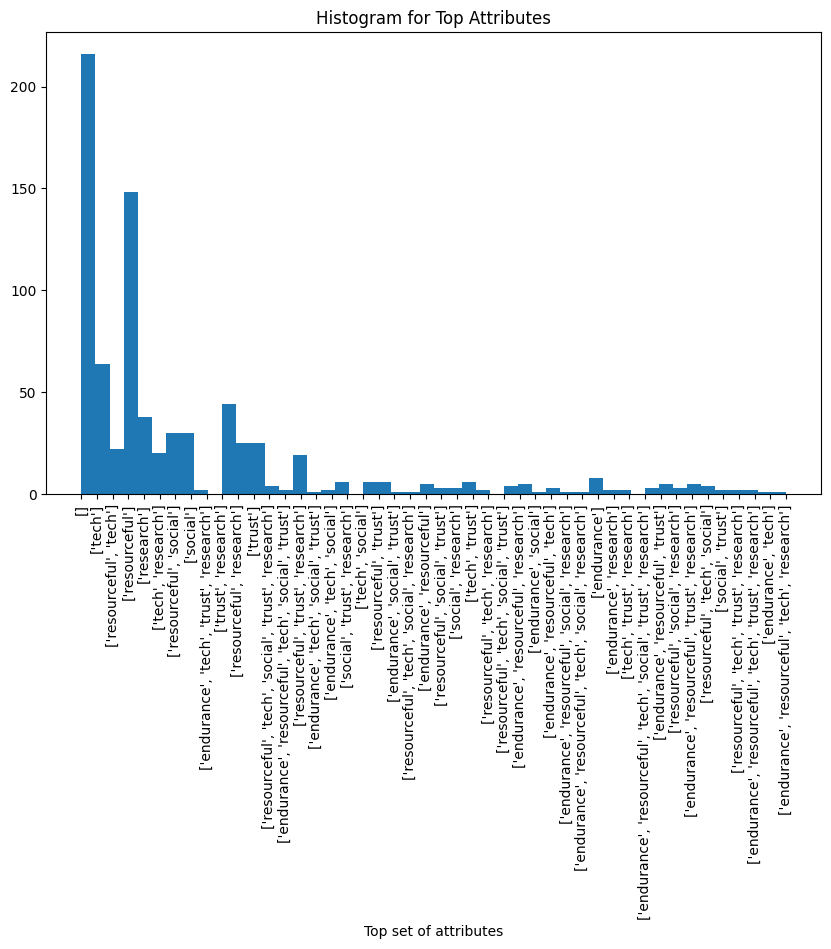

In [16]:
#top attributes
f, ax = plt.subplots(figsize= (10,6))
ax.hist(df_column, bins=50)
ax.set_xlabel("Top set of attributes")
ax.set_title("Histogram for Top Attributes")
plt.xticks(rotation=90)



In [17]:
df_column = df_session['WorstAttribute-Names'] #column must be integers


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 [Text(0, 0, '[]'),
  Text(1, 0, "['research']"),
  Text(2, 0, "['endurance', 'social', 'trust', 'research']"),
  Text(3, 0, "['endurance', 'tech']"),
  Text(4, 0, "['endurance']"),
  Text(5, 0, "['endurance', 'research']"),
  Text(6, 0, "['endurance', 'tech', 'social', 'trust', 'research']"),
  Text(7, 0, "['endurance', 'tech', 'research']"),
  Text(8, 0, "['resourceful', 'social']"),
  Text(9, 0, "['endurance', 'resourceful', 'tech', 'social']"),
  Text(10, 0, "['endurance', 'resourceful', 'social']"),
  Text(11, 0, "['endurance', 'social']"),
  Text(12, 0, "['endurance', 'tech', 'social']"),
  Text(13, 0, "['endurance', 'tech', 'trust', 'research']"),
  Text(14, 0, "['endurance', 'trust']"),
  Text(15, 0, "['

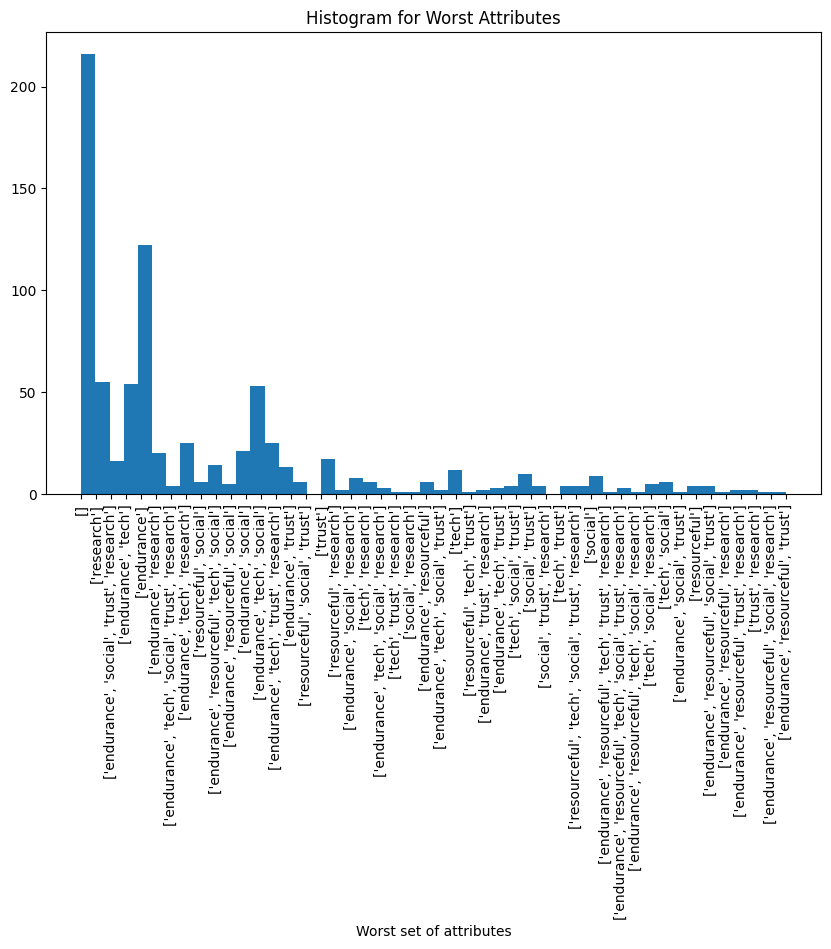

In [18]:
#jobs completed
f, ax = plt.subplots(figsize= (10,6))
ax.hist(df_column, bins=50)
ax.set_xlabel("Worst set of attributes")
ax.set_title("Histogram for Worst Attributes")
plt.xticks(rotation=90)


In [19]:
df_column = df_session['QuitLevel-EventName'] 
#or df_column = df_session['QuitLevel-NodeID']

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'display_text_dialog'),
  Text(1, 0, 'stat_update'),
  Text(2, 0, 'text_click'),
  Text(3, 0, 'change_background_image'),
  Text(4, 0, 'display_choices'),
  Text(5, 0, 'open_map_tab'),
  Text(6, 0, 'story_updated'),
  Text(7, 0, 'display_feedback_dialog'),
  Text(8, 0, 'open_timer'),
  Text(9, 0, 'open_notebook'),
  Text(10, 0, 'display_snippet_quality_dialog'),
  Text(11, 0, 'time_expired'),
  Text(12, 0, 'show_popup_image'),
  Text(13, 0, 'display_published_story'),
  Text(14, 0, 'story_click'),
  Text(15, 0, 'action_choice_click'),
  Text(16, 0, 'editor_notes_open'),
  Text(17, 0, 'hub_choice_click'),
  Text(18, 0, 'time_elapsed'),
  Text(19, 0, 'change_location'),
  Text(20, 0, 'open_impact_map'),
  Text(21, 0, 'select_snippet'),
  Text(22, 0, 'close_stats_tab')])

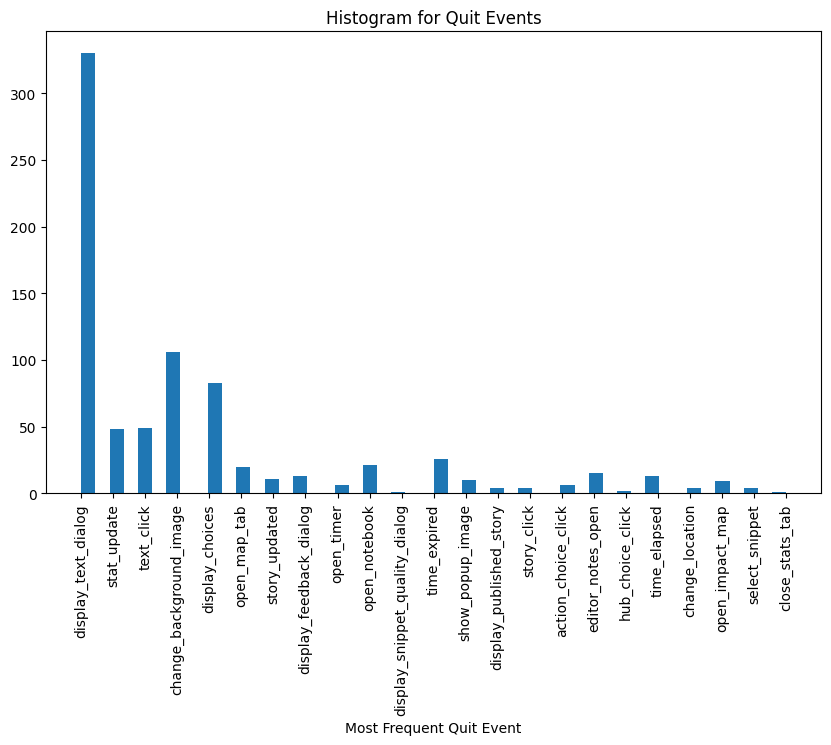

In [20]:
#jobs completed
f, ax = plt.subplots(figsize= (10,6))
ax.hist(df_column, bins=50)
ax.set_xlabel("Most Frequent Quit Event")
ax.set_title("Histogram for Quit Events")
plt.xticks(rotation=90)

In [21]:
df_column = df_session['QuitLevel'] #column must be integers


The average amount of levels completed: 1.7048346055979644


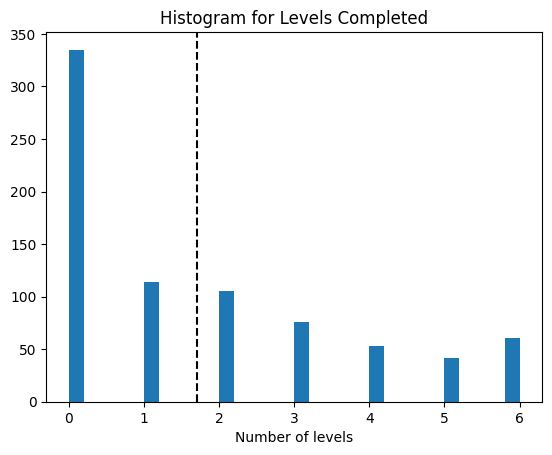

In [22]:
#jobs completed
f, ax = plt.subplots()
ax.hist(df_column, bins=30)
ax.axvline(x=df_column.mean(), linestyle='--', color='k', label="Median")
ax.set_xlabel("Number of levels")
ax.set_title("Histogram for Levels Completed")
print(f'The average amount of levels completed: {df_column.mean()}')

/tmp/ipykernel_480/2612279508.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_session[target_cols].hist(ax=ax, bins = 2)


array([[<Axes: title={'center': 'lvl1_LevelCompleted'}>,
        <Axes: title={'center': 'lvl2_LevelCompleted'}>],
       [<Axes: title={'center': 'lvl3_LevelCompleted'}>,
        <Axes: title={'center': 'lvl4_LevelCompleted'}>],
       [<Axes: title={'center': 'lvl5_LevelCompleted'}>, <Axes: >]],
      dtype=object)

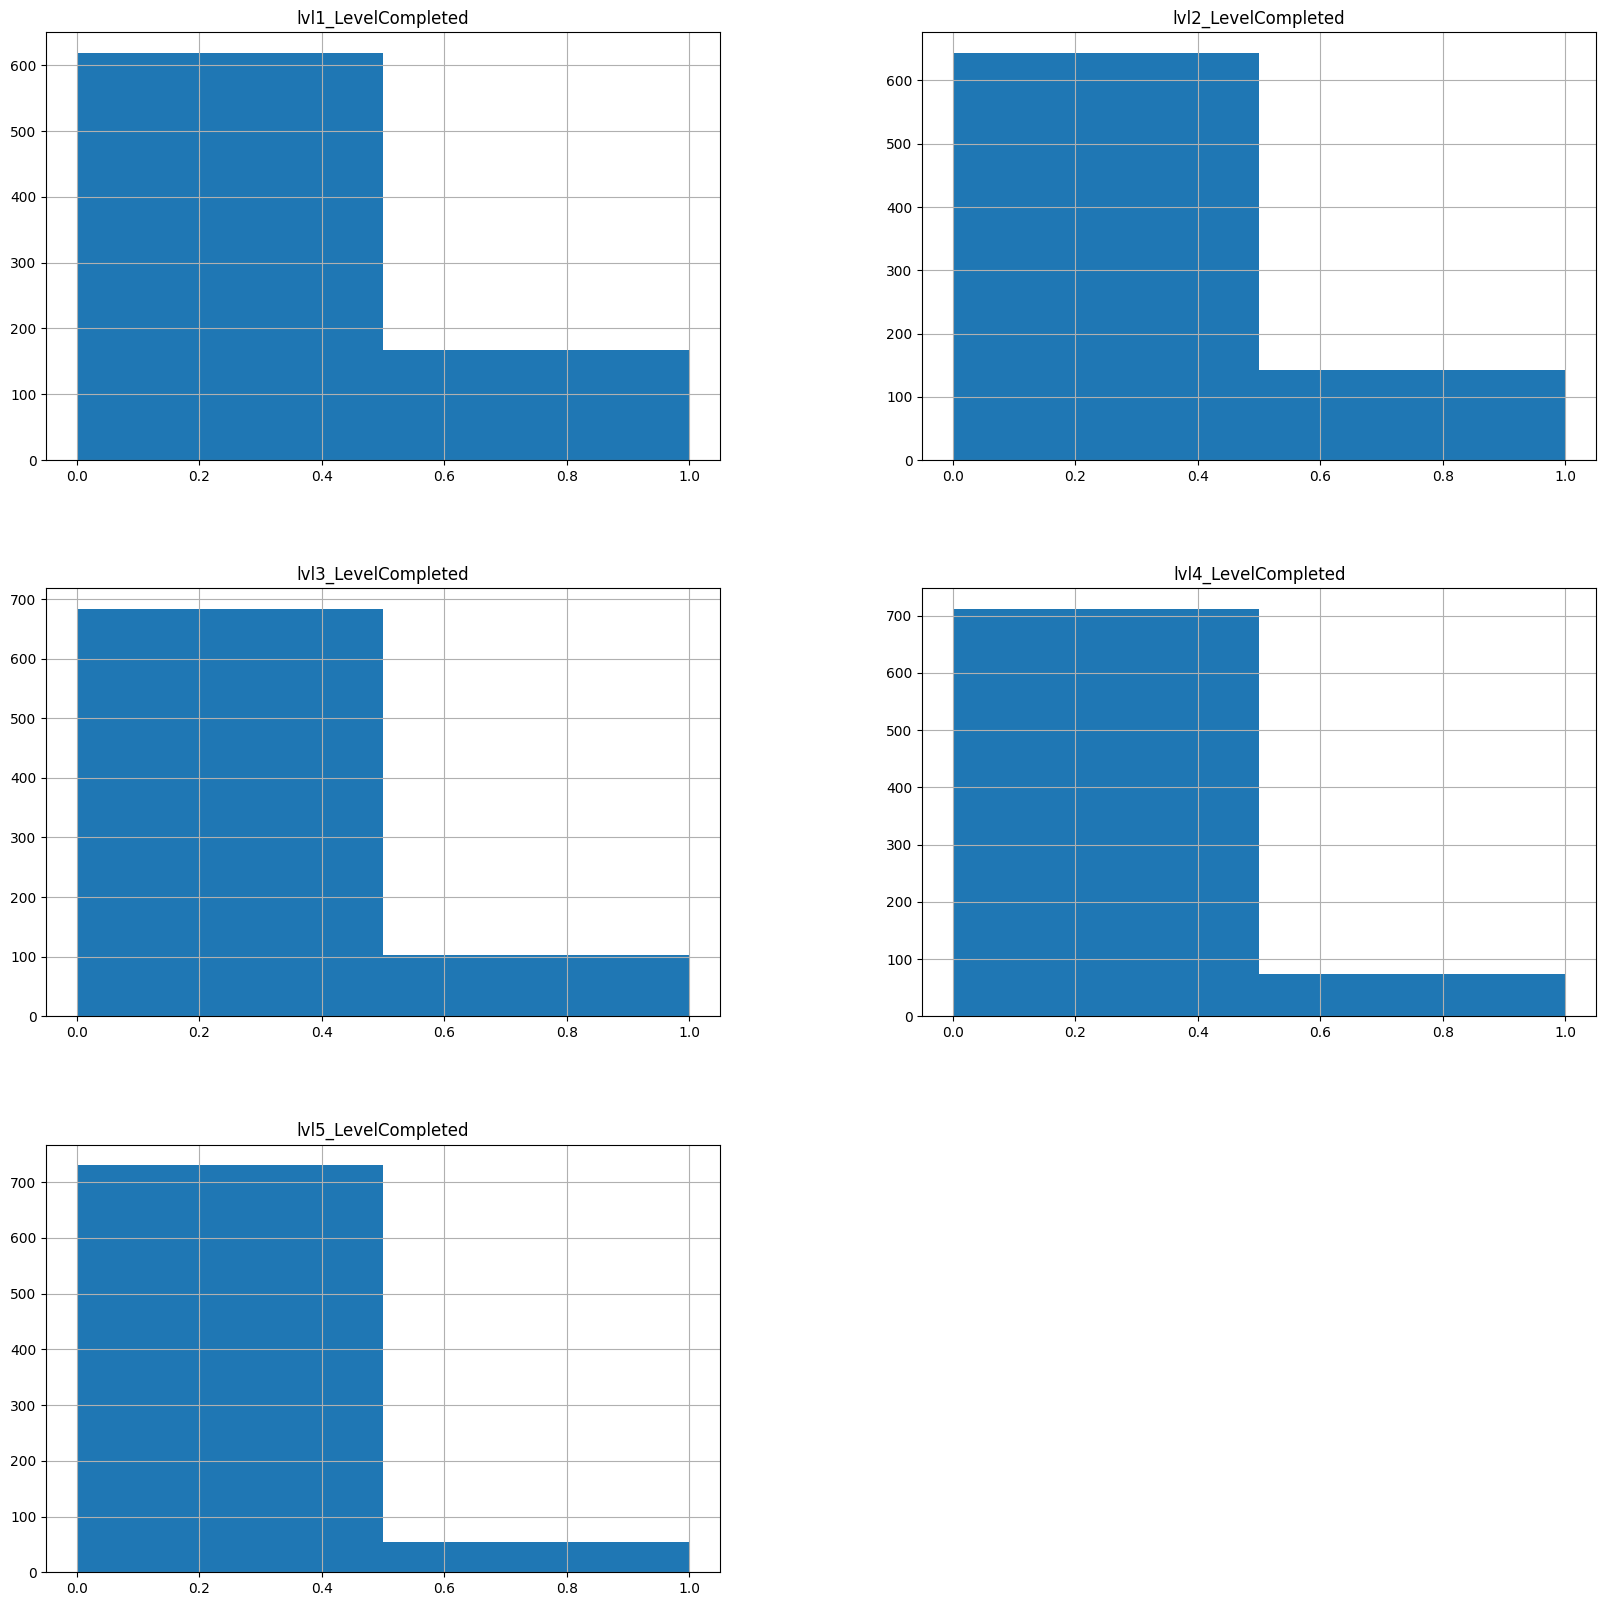

In [23]:
target_cols = ['lvl1_LevelCompleted', 'lvl2_LevelCompleted', 'lvl3_LevelCompleted',
       'lvl4_LevelCompleted', 'lvl5_LevelCompleted']
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_session[target_cols].hist(ax=ax, bins = 2)


In [24]:
#scatter plot columns
col1 = 'PlayTime' #@param{type:"string"}
col2 = 'PlayTime-Idle Time'#@param{type:"string"}

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

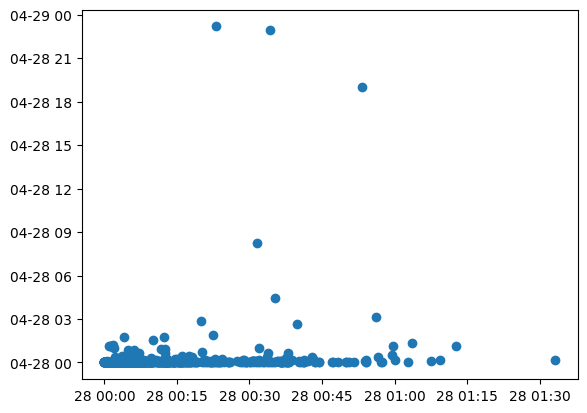

In [25]:
#jobs completed
plt.scatter(df_session[col1], df_session[col2])
m, b = np.polyfit(df_session[col1], df_session[col2], 1)
plt.plot(df_session[col1], m*df_session[col1]+b, color = 'red')
plt.xlabel(col1)
plt.ylabel(col2)
print(f'Slope of line: {(m*df_session[col1]+b).mean()}')

In [ ]:
df_session[df_session['PlayTime-Idle Time'] > datetime.utcfromtimestamp(0)]

,PlayerID,SessionID,PlayTime,PlayTime-Total Time,PlayTime-Idle Time,PlayerAttributes,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,...,lvl3_LevelCompleted,lvl4_LevelCompleted,lvl5_LevelCompleted,lvl1_LevelStoryAlignment,lvl2_LevelStoryAlignment,lvl3_LevelStoryAlignment,lvl4_LevelStoryAlignment,lvl5_LevelStoryAlignment,ContinuesOnFail,GameComplete
4,SeveralFridge,23040212171216016,2023-04-27 00:00:00.000,2023-04-27 00:00:00.000,2023-04-27 00:00:00,"[0, 0, 0, 0, 0, 0]",0,display_text_dialog,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
5,EnoughRally,23040214002714806,2023-04-27 00:43:39.000,2023-04-27 00:43:39.000,2023-04-27 00:00:00,"[3,3,5,3,4,1]",5,display_text_dialog,@0C9004F8,OnFail,...,1,1,0,0.229,0.800,0.633,0.34,0.0,1,0
6,SmartestIcicle,23040215195158578,2023-04-27 00:41:06.000,2023-04-27 00:41:06.000,2023-04-27 00:00:00,"[1,4,5,4,4,0]",5,display_text_dialog,@0C9004F8,Other,...,1,1,0,-0.031,0.559,0.300,0.00,0.0,1,0
7,QuickFax,23040216160241931,2023-04-27 00:01:31.000,2023-04-27 00:01:31.000,2023-04-27 00:00:00,"[1,2,2,1,1,1]",0,stat_update,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
8,CirclingPencil,23040216182351934,2023-04-27 00:08:19.000,2023-04-27 00:10:13.000,2023-04-27 00:01:53,"[1,3,1,2,2,2]",1,text_click,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,AbnormalDozen,23042113214030054,2023-04-27 00:02:53.267,2023-04-27 00:02:53.267,2023-04-27 00:00:00,"[1,3,1,2,2,2]",0,display_text_dialog,SnagPhotosLowTime,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
786,FondToad,23042114180700609,2023-04-27 00:04:14.894,2023-04-27 00:04:14.894,2023-04-27 00:00:00,"[1,3,1,2,2,2]",0,display_choices,none,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
787,CottonyStylus,23042114321567240,2023-04-27 00:02:07.005,2023-04-27 00:02:07.005,2023-04-27 00:00:00,"[1,2,1,1,3,3]",0,time_expired,TakeSomePhotos,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
788,AdoredSlip,23042114323708674,2023-04-27 00:01:52.754,2023-04-27 00:01:52.754,2023-04-27 00:00:00,"[1,1,2,1,3,3]",0,stat_update,ChaseChickens,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0


In [ ]:
df_session

,PlayerID,SessionID,PlayTime,PlayTime-Total Time,PlayTime-Idle Time,PlayerAttributes,QuitLevel,QuitLevel-EventName,QuitLevel-NodeID,QuitType,...,lvl3_LevelCompleted,lvl4_LevelCompleted,lvl5_LevelCompleted,lvl1_LevelStoryAlignment,lvl2_LevelStoryAlignment,lvl3_LevelStoryAlignment,lvl4_LevelStoryAlignment,lvl5_LevelStoryAlignment,ContinuesOnFail,GameComplete
4,SeveralFridge,23040212171216016,0:00:00.708000,0:00:00.708000,0:00:00,"[0, 0, 0, 0, 0, 0]",0,display_text_dialog,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
5,EnoughRally,23040214002714806,0:43:39.086000,0:43:39.086000,0:00:00,"[3,3,5,3,4,1]",5,display_text_dialog,@0C9004F8,OnFail,...,1,1,0,0.229,0.800,0.633,0.34,0.0,1,0
6,SmartestIcicle,23040215195158578,0:41:06.259000,0:41:06.259000,0:00:00,"[1,4,5,4,4,0]",5,display_text_dialog,@0C9004F8,Other,...,1,1,0,-0.031,0.559,0.300,0.00,0.0,1,0
7,QuickFax,23040216160241931,0:01:31.366000,0:01:31.366000,0:00:00,"[1,2,2,1,1,1]",0,stat_update,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
8,CirclingPencil,23040216182351934,0:08:19.177000,0:10:13.122000,0:01:53.945000,"[1,3,1,2,2,2]",1,text_click,@0C9004F8,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,AbnormalDozen,23042113214030054,0:02:53.267000,0:02:53.267000,0:00:00,"[1,3,1,2,2,2]",0,display_text_dialog,SnagPhotosLowTime,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
786,FondToad,23042114180700609,0:04:14.894000,0:04:14.894000,0:00:00,"[1,3,1,2,2,2]",0,display_choices,none,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
787,CottonyStylus,23042114321567240,0:02:07.005000,0:02:07.005000,0:00:00,"[1,2,1,1,3,3]",0,time_expired,TakeSomePhotos,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
788,AdoredSlip,23042114323708674,0:01:52.754000,0:01:52.754000,0:00:00,"[1,1,2,1,3,3]",0,stat_update,ChaseChickens,Other,...,0,0,0,0.000,0.000,0.000,0.00,0.0,0,0
